<a href="https://colab.research.google.com/github/Sanele098/Comp-700---Project/blob/main/Music_Recommender_System_Collaborative_filtering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix
#from recommeders.knn_recommender import Recommender

In [4]:
#Loading the data
from google.colab import files
uploaded = files.upload()

Saving song_data.csv to song_data.csv


In [5]:
#Read userid-songid-listen_count
song_info = pd.read_csv('10000.txt',sep='\t',header=None)
song_info.columns = ['user_id', 'song_id', 'listen_count']

#Read song  metadata
song_actual =  pd.read_csv('song_data.csv')
song_actual.drop_duplicates(['song_id'], inplace=True)

#Merge the two dataframes above to create input dataframe for recommender systems
songs = pd.merge(song_info, song_actual, on="song_id", how="left")

In [6]:
songs.to_csv('songs.csv', index=False)
df_songs = pd.read_csv('songs.csv')
df_songs.head()

,user_id,song_id,listen_count,title,release,artist_name,year
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1,The Cove,Thicker Than Water,Jack Johnson,0
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2,Entre Dos Aguas,Flamenco Para Niños,Paco De Lucia,1976
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1,Stronger,Graduation,Kanye West,2007
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1,Constellations,In Between Dreams,Jack Johnson,2005
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1,Learn To Fly,There Is Nothing Left To Lose,Foo Fighters,1999


In [7]:
#Get total observations
print(f"There are {df_songs.shape[0]} observations in the dataset")

There are 2000000 observations in the dataset


In [21]:
df_songs.isnull().sum()

user_id         0
song_id         0
listen_count    0
title           0
release         0
artist_name     0
year            0
dtype: int64

In [8]:
#Unique songs
unique_songs = df_songs['title'].unique().shape[0]
print(f"There are {unique_songs} unique songs in the dataset")

There are 9567 unique songs in the dataset


In [9]:
#Unique artists
unique_artists = df_songs['artist_name'].unique().shape[0]
print(f"There are {unique_artists} unique artists in the dataset")

There are 3375 unique artists in the dataset


In [10]:
#Unique users
unique_users = df_songs['user_id'].unique().shape[0]
print(f"There are {unique_users} unique users in the dataset")

There are 76353 unique users in the dataset


In [11]:
#count how many rows we have by song, we show only the ten more popular songs 
ten_pop_songs = df_songs.groupby('title')['listen_count'].count().reset_index().sort_values(['listen_count', 'title'], ascending = [0,1])
ten_pop_songs['percentage']  = round(ten_pop_songs['listen_count'].div(ten_pop_songs['listen_count'].sum())*100, 2)

In [12]:
ten_pop_songs = ten_pop_songs[:10]
ten_pop_songs

,title,listen_count,percentage
6836,Sehr kosmisch,8277,0.41
8725,Undo,7032,0.35
1964,Dog Days Are Over (Radio Edit),6949,0.35
9496,You're The One,6729,0.34
6498,Revelry,6145,0.31
6825,Secrets,5841,0.29
3437,Horn Concerto No. 4 in E flat K495: II. Romanc...,5385,0.27
2595,Fireflies,4795,0.24
3322,Hey_ Soul Sister,4758,0.24
8494,Tive Sim,4548,0.23


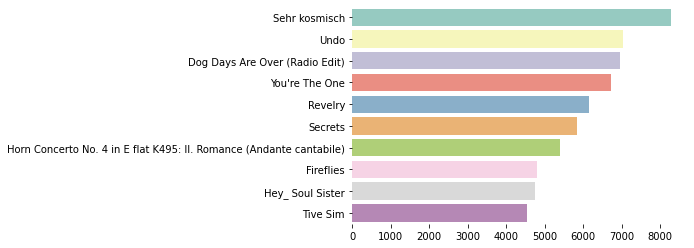

In [13]:
labels = ten_pop_songs['title'].tolist()
counts = ten_pop_songs['listen_count'].tolist()
plt.figure()
sns.barplot(x=counts, y=labels, palette='Set3')
sns.despine(left=True, bottom=True)

**Most popular artist**

For the next task, we'll count how many times each artist appears. Again, we'll count how many times the same artist appears.

In [14]:
#count how many rows we have by artist name, we show only the ten more popular artist 
ten_pop_artists  = df_songs.groupby(['artist_name'])['listen_count'].count().reset_index().sort_values(['listen_count', 'artist_name'], 
                                                                                                ascending = [0,1])
ten_pop_artists = ten_pop_artists[:10]
ten_pop_artists

,artist_name,listen_count
649,Coldplay,29422
2850,The Black Keys,19862
1651,Kings Of Leon,18747
1107,Florence + The Machine,18112
1370,Jack Johnson,17801
2946,The Killers,16063
2374,Radiohead,14890
736,Daft Punk,14715
2073,Muse,14005
1554,Justin Bieber,13959


**Listen count by user**

We can also get some other information from the feature listen_count. We will answer the folloging questions:
What was the maximum time the same user listen to a same song?

In [15]:
listen_counts = pd.DataFrame(df_songs.groupby('listen_count').size(), columns=['count'])
print(f"The maximum time the same user listened to the same songs was: {listen_counts.reset_index(drop=False)['listen_count'].iloc[-1]}")

The maximum time the same user listened to the same songs was: 2213


In [16]:
print(f"On average, a user listen to the same song {df_songs['listen_count'].mean()} times")

On average, a user listen to the same song 3.0454845 times


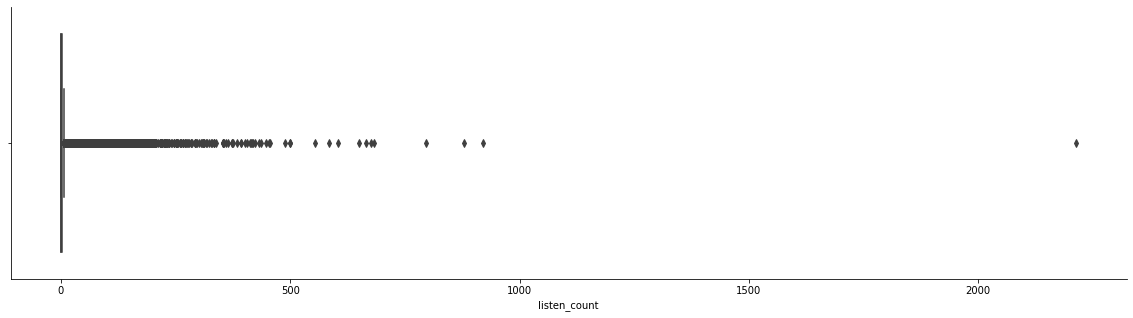

In [17]:
plt.figure(figsize=(20, 5))
sns.boxplot(x='listen_count', data=df_songs)
sns.despine()


What are the most frequent number of times a user listen to the same song?

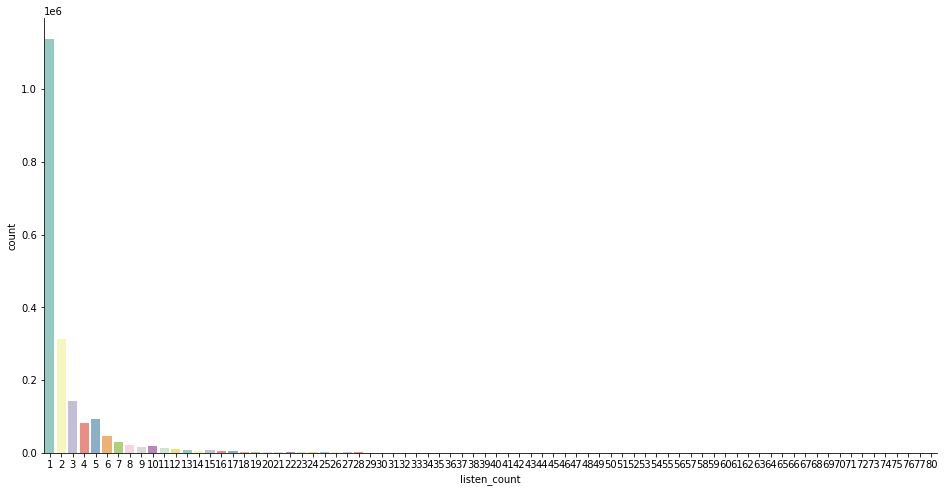

In [18]:
listen_counts_temp = listen_counts[listen_counts['count'] > 50].reset_index(drop=False)
plt.figure(figsize=(16, 8))
sns.barplot(x='listen_count', y='count', palette='Set3', data=listen_counts_temp)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show();

**How many songs does a user listen in average?**

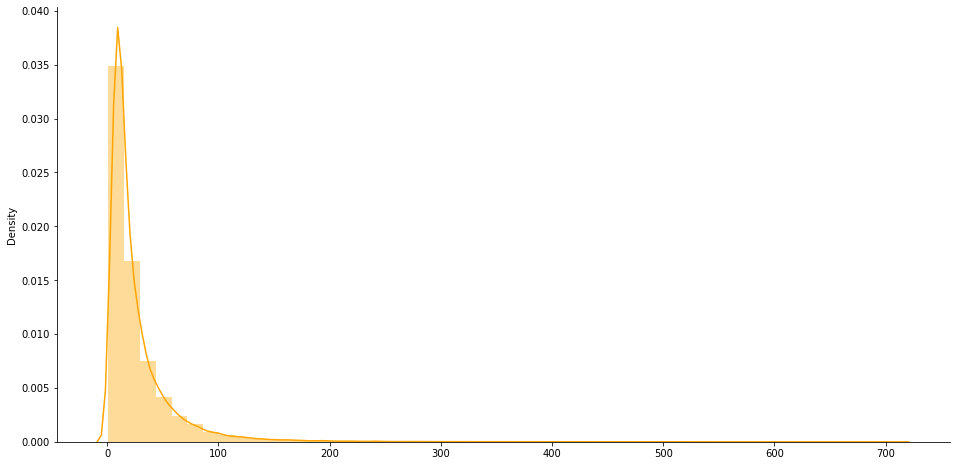

In [19]:
song_user = df_songs.groupby('user_id')['song_id'].count()
plt.figure(figsize=(16, 8))
sns.distplot(song_user.values, color='orange')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show();

**Prepareing the data for Recommendation**

In [20]:
# Get users which have listen to at least 16 songs
song_ten_id = song_user[song_user > 16].index.to_list()

In [21]:
print(f"A user listens to an average of {np.median(song_user)} songs, with minimum {np.min(song_user)} and maximum {np.max(song_user)} songs")

A user listens to an average of 16.0 songs, with minimum 1 and maximum 711 songs


In [22]:
# Get how many values should it be if all songs have been listen by all users
values_matrix = unique_users * unique_songs

In [23]:
# Substract the total values with the actural shape of the DataFrame songs
zero_values_matrix = values_matrix - df_songs.shape[0]

In [24]:
print(f"The matrix of users x songs has {zero_values_matrix} values that are zero")

The matrix of users x songs has 728469151 values that are zero


**Preparing the data**

In [25]:
# Get users which have listen to at least 16 songs
song_ten_id = song_user[song_user > 16].index.to_list()

In [26]:
# Filtered the dataset to keep only those users with more than 16 listened
df_song_id_more_ten = df_songs[df_songs['user_id'].isin(song_ten_id)].reset_index(drop=True)

We need now to work with a scipy-sparse matrix to avoid overflow and wasted memory. For that purpose, we'll use the csr_matrix function from scipy.sparse.

In [27]:
# convert the dataframe into a pivot table
df_songs_features = df_song_id_more_ten.pivot(index='song_id', columns='user_id', values='listen_count').fillna(0)

# obtain a sparse matrix
mat_songs_features = csr_matrix(df_songs_features.values)

In [28]:
df_songs_features.head()

user_id,000e2c2a8c7870ff9121f212b35c8b3a20cc0e67,000ebc858861aca26bac9b49f650ed424cf882fc,000ef25cc955ad5841c915d269432eea41f4a1a5,0012bf75d43a724f62dc746d9e85ae0088a3a1d6,001322829b5dc3edc59bf78189617ddd8f23c82a,00185e316f07f0f00c325ca034be59c15b362401,0019740e3e8c24e223a6f88e3faa7c144ec5a014,001b005fe5e80d3cb45f320f5658fc8e2e72794e,001f22c638730aed5659034c447d3cf0e658898e,0021d9a4628624f6d70237f9c200ab82e766bf26,002543003041db1d049206b09426d5cdffc0f451,0028292aa536122c1f86fd48a39bd83fe582d27f,00292cf9c6d6e99c5ddbece7e37f957ab1362d25,00296f66ed7fb84c876486aecc9fab2d5809576d,0030822badc23ef6500a72ce7feda1c63faf2262,0031572620fa7f18487d3ea22935eb28410ecc4c,003412e33eb3d05573f7811c1ba61d6a15be5690,00342a0cdf56a45465f09a39040a5bc25b7d0046,00388e5764c59488ec06a109c88b39f59a2b6361,0039bd8483d578997718cdc0bf6c7c88b679f488,003ac50a4e6ed0c9085fecb7a1738730e7ea4942,003bfb50126f91f6389aaee733f5b3e0a8d5cbe0,003d0f3aac94fd261bb74c0124a90750579972d4,003d21762b29fe2ffe20fb9a51eb1e02ebeb3242,003d6d799d58e1fce362f5f4f6c7bcc26c8f3546,003e3919f41dbb8ff05a75623d205f6abcede4fc,003f1064ed75d1156352cd89b25fb752bcc10b13,003f1e939952a57d1a5bc990727acad5ceea97b4,00409f6a83c2bf4299ab6ae2dea958050537b5a9,0041925615557845642a7b1257fdc6229fe1ee5d,00454c72c0b4b99f9cc81ba0b1989597a43669d6,0045c60d98ced5efb3cbf1e0b4b7de1da3f1a506,00488ec44caa0d2fa669780f8cb604bf39e94392,004c7be9336ca88824e1e0b09ef9a2168200fa33,004dc9f93f5ad4a75f9a3ba0da5dd887b31d6bd2,004f6065fa9840913f62e52d94d9c29ea1d26fe1,004fcdf8829d68f4e45ef846ad9f308c4493ed8e,0051a2e7b452e3dc67f48688442032df557897f4,00544d8bde0d7985e8d703c1eb676d41cad33c67,00546de8971645143eead323561d0298d5b0f2be,...,ffb63da2222280f299a7a896edea073728aab343,ffb7096f3eeee706825b4a8c3fab98ce0e0b4216,ffb8299fcb3f31716c93fb8a77dee0d1dbb210f9,ffba3563fd590a51dabc1dfcb8a27119e6035241,ffbc58b89c81227a08ee05d90259bdd9172b9479,ffbe437f18c3bea5c78596c5f3183ee62d440b6c,ffc2563e7dd136bf371371cd21f0cc404a1d7499,ffc564b85d81f0ea427cee3eea2415cc2fc5c4be,ffc5b3bd0575330eb8c4ae4f3b9cabd3ba315dbb,ffc66b4520671da6b2a67a0326201565160d9650,ffc9966885909a0b42493b2558be9dc451317488,ffcc2cff250ea22471df09e76f59e2be0debae72,ffcfb0b34a47fdf55b3d96c1799cd196677f8261,ffd1d617221f5bf00de80ee3eb5d2a17fc8d077d,ffd25d7da8b4e54ea2cde25dd3b52d0e0aef7a5d,ffd458f903d49854685cf4540245c1d297e8bafa,ffd6f34b343cee62cd7dbbf20fb1ab1119b299e5,ffda2736b2204ece3b19e941caacad4106d00ed5,ffdaab327f2fc6b9fa01a4e3e7f41fdd0e468046,ffdb5557e4e24da051ebd6b45ec18c524c55dc40,ffdbaeb5cf2081eb34053a655c20f57524de11ba,ffde97c0d23bf5ce249ce73e630ccb4e7293cc32,ffe2a7e7b6689071f8c699d944b52ce590ae4636,ffe33dce4e652a4dc4824cc39680a9f709cfdfb3,ffebfec313fd515a11faba060b022f030b57fac0,ffecbb84f3dde31b0b2e64d70b7b7e5092bf7427,ffef9c3e59ab44554a9775af5e3b2ac149111bb6,fff03efd1550136063389fa71125194614e1c68f,fff0b1ab076f0b71cbde9c7dcbcfca400708d845,fff22417a61c1ba3ee2592b22a052ed6a27a8e91,fff300cd094fe04030b79fae550dc9d065190182,fff4676dacb2e9a7217702f62ee70e88aa512ecc,fff4e1a7dacbe9c13051c08f09bf66d76cbee35e,fff543db7918cb8f4f56f7470903eb2f1d5a6dd8,fff6c30c773e6ffafcac213c9afd9666afaf6d63,fffb701ee87a32eff67eb040ed59146121f01571,fffc0df75a48d823ad5abfaf2a1ee61eb1e3302c,fffce9c1537fbc350ea68823d956eaa8f5236dbe,fffd9635b33f412de8ed02e44e6564e3644cf3c6,fffea3d509760c984e7d40789804c0e5e289cc86
song_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
SOAAAGQ12A8C1420C8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SOAACPJ12A81C21360,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

Because the system will output the id of the song, instead of the title, we'll make a function that maps those indices with the song title.

In [29]:
df_unique_songs = df_songs.drop_duplicates(subset=['song_id']).reset_index(drop=True)[['song_id', 'title']]
decode_id_song = {
    song: i for i, song in 
    enumerate(list(df_unique_songs.set_index('song_id').loc[df_songs_features.index].title))
}

**Model and recommendations**

So, we know that we want to use the model to predict songs. For that, we'll use the Recommender class wrote in the knn_recommender file.

In [34]:
from sklearn.neighbors import NearestNeighbors
from fuzzywuzzy import fuzz
import numpy as np

class Recommender:
    def __init__(self, metric, algorithm, k, data, decode_id_song):
        self.metric = metric
        self.algorithm = algorithm
        self.k = k
        self.data = data
        self.decode_id_song = decode_id_song
        self.data = data
        self.model = self._recommender().fit(data)
    
    def make_recommendation(self, new_song, n_recommendations):
        recommended = self._recommend(new_song=new_song, n_recommendations=n_recommendations)
        print("_______ *** Done *** ________")
        return recommended 
    
    def _recommender(self):
        return NearestNeighbors(metric=self.metric, algorithm=self.algorithm, n_neighbors=self.k, n_jobs=-1)
    
    def _recommend(self, new_song, n_recommendations):
        # Get the id of the recommended songs
        recommendations = []
        recommendation_ids = self._get_recommendations(new_song=new_song, n_recommendations=n_recommendations)
        # return the name of the song using a mapping dictionary
        recommendations_map = self._map_indeces_to_song_title(recommendation_ids)
        # Translate this recommendations into the ranking of song titles recommended
        for i, (idx, dist) in enumerate(recommendation_ids):
            recommendations.append(recommendations_map[idx])
        return recommendations
                 
    def _get_recommendations(self, new_song, n_recommendations):
        # Get the id of the song according to the text
        recom_song_id = self._fuzzy_matching(song=new_song)
        # Start the recommendation process
        print(f"Starting the recommendation process for {new_song} ...")
        # Return the n neighbors for the song id
        distances, indices = self.model.kneighbors(self.data[recom_song_id], n_neighbors=n_recommendations+1)
        return sorted(list(zip(indices.squeeze().tolist(), distances.squeeze().tolist())), key=lambda x: x[1])[:0:-1]
    
    def _map_indeces_to_song_title(self, recommendation_ids):
        # get reverse mapper
        return {song_id: song_title for song_title, song_id in self.decode_id_song.items()}
    def _fuzzy_matching(self, song):
        match_tuple = []
        # get match
        for title, idx in self.decode_id_song.items():
            ratio = fuzz.ratio(title.lower(), song.lower())
            if ratio >= 60:
                match_tuple.append((title, idx, ratio))
        # sort
        match_tuple = sorted(match_tuple, key=lambda x: x[2])[::-1]
        if not match_tuple:
            print(f"The recommendation system could not find a match for {song}")
            return
        return match_tuple[0][1]
    
    

In [35]:
model = Recommender(metric='cosine', algorithm='brute', k=20, data=mat_songs_features, decode_id_song=decode_id_song)
song = 'I believe in miracles'
new_recommendations = model.make_recommendation(new_song=song, n_recommendations=10)

Starting the recommendation process for I believe in miracles ...
_______ *** Done *** ________


In [36]:
print(f"The recommendations for {song} are:")
#print(f"{new_recommendations}")
for x in new_recommendations:
  print(f"{x}")

The recommendations for I believe in miracles are:
Nine Million Bicycles
If You Were A Sailboat
Shy Boy
I Cried For You
Spider's Web
Piece By Piece
On The Road Again
Blues In The Night
Blue Shoes
Thank You Stars
